[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [54]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns

import torch
from torch.nn import Sequential, Softmax, LeakyReLU, PReLU
from torch.optim import Adam

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from callbacks import PlotMetrics, \
                      Logger, \
                      ReduceLROnPlateau, \
                      TrainValLossComputer, \
                      TrainValAccuracyComputer

from model import CommonModel, \
                  softmax_cross_entropy_fn, \
                  softmax_pred_out, \
                  dense_stack

from utils import try_gpu
from callbacks import CallbackSet

from metrics import show_summary

from data import OverUnderSampler, to_single_col_df

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

from plot import plot_hist, local_bin

In [12]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')

In [13]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [14]:
INDIVIDUAL_FEATURES = [
    'Overal',
    'Potential',
    'Height',
    'Weight',
    'PreferredFoot',
    'Age',
    'PlayerWorkRate',
    'WeakFoot',
    'SkillMoves', 
    'Value',
    'Wage',
    'Club',
    'Club_KitNumber',
    'Club_JoinedClub',
    'Club_ContractLength'
]

SKILL_FEATURES = [
    'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression',
    'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass',
    'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed',
    'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots',
    'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKReflexes'
]
TARGET = 'Position'

CAL_COLS = [ 'PreferredFoot', 'PlayerWorkRate']

In [15]:
def columns_with_missing(df): return [col for col in df.columns if df[col].isnull().any()]

In [16]:
feature_columns = list(set(INDIVIDUAL_FEATURES + SKILL_FEATURES) -  set(columns_with_missing(train_set)))

In [17]:
train_set = train_set[feature_columns + [TARGET]]

In [18]:
def preprocess(df): 
    features = df[feature_columns]
    for col in CAL_COLS:
        features = pd.concat([features, pd.get_dummies(features[col], dummy_na=False)], axis=1)
    features = features.drop(CAL_COLS, axis=1)
    
    target = pd.get_dummies(df[[TARGET]], dummy_na=False) if TARGET in df.columns else None

    return features, target

In [19]:
def plot_df_clases_count(df, class_col):
    groups = train_set[[class_col]] \
      .groupby(class_col) \
      .size() \
      .reset_index(name='count')
    sns.barplot(data=groups, x=class_col, y='count')

def plot_array_clases_count(values):
    groups = values \
        .mean() \
        .reset_index(name='count') \
        .rename(columns={"index": "Name"})

    sns.barplot(data=groups, x="Name", y='count')

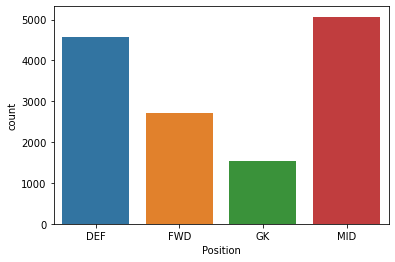

In [20]:
plot_df_clases_count(train_set, TARGET)

In [39]:
X, y = preprocess(train_set)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=train_set[TARGET])

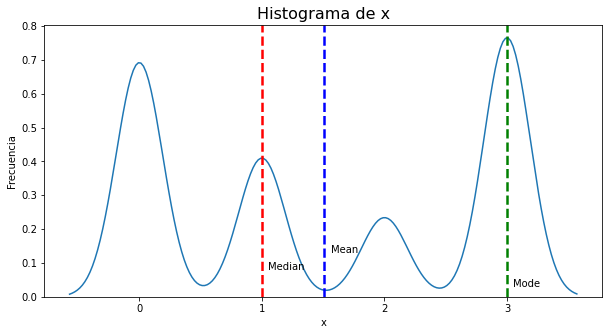

In [108]:
plot_hist(lambda: pd.DataFrame(y.values.argmax(1)).values)

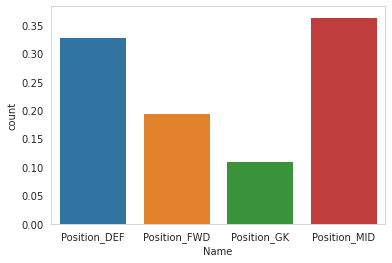

In [38]:
plot_array_clases_count(y_train)

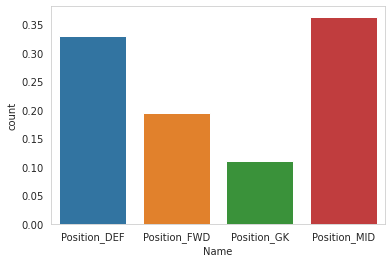

In [39]:
plot_array_clases_count(y_val)

In [40]:
sampler = OverUnderSampler()

X_train_bal, y_train_bal = sampler.perform(X_train, y_train)

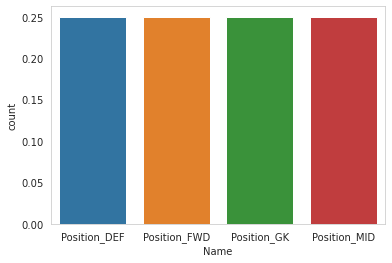

In [41]:
plot_array_clases_count(y_train_bal)

In [42]:
class MyModel(CommonModel):
    def __init__(self, n_units, lr=0.001, dropout=0.2):
        model = Sequential(*dense_stack(n_units, LeakyReLU(negative_slope=0.02), dropout), Softmax(dim=1)).to(device=try_gpu())
        super().__init__(model, softmax_cross_entropy_fn, Adam(model.parameters(), lr=lr), softmax_pred_out)

In [43]:
model = MyModel(
    n_units = [X_train.shape[1], 100, y_train.shape[1]],
    lr      = 0.01,
    dropout = 0.2
).info()

Model:
 Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.02)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=100, out_features=4, bias=True)
  (4): LeakyReLU(negative_slope=0.02)
  (5): Dropout(p=0.2, inplace=False)
  (6): Softmax(dim=1)
)
Params:
 [('0.weight', torch.Size([100, 50])), ('0.bias', torch.Size([100])), ('3.weight', torch.Size([4, 100])), ('3.bias', torch.Size([4]))]


### Train

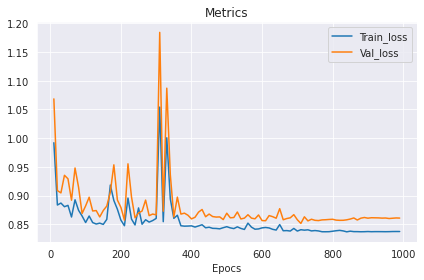

{'epoch': 1000, 'lr': 1e-05, 'train_loss': 0.8374178409576416, 'val_loss': 0.8609768152236938, 'train_acc': 0.9061130587204207, 'val_acc': 0.9008537339985303}


In [44]:
model.fit(
    train_set    = (X_train_bal, y_train_bal), 
    val_set      = (X_val, y_val),
    batch_size   = 512,
    epochs       = 1000,
    callback_set = CallbackSet([
        TrainValLossComputer(),
        TrainValAccuracyComputer(),
        PlotMetrics(metrics=['train_loss', 'val_loss']),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'lr']),
        ReduceLROnPlateau(patience=150)
    ])
)

### Predict on validation

In [45]:
y_true       = to_single_col_df(np.argmax(y_val.values, axis=1))
y_pred       = to_single_col_df(model.predict(X_val))
y_pred_proba = model.predict_proba(X_val)

Accuracy: 90.0854 %

Classification Report:
              precision    recall  f1-score   support

Position_DEF       0.94      0.95      0.94       459
Position_FWD       0.76      0.85      0.80       272
 Position_GK       1.00      1.00      1.00       155
Position_MID       0.87      0.80      0.83       507

    accuracy                           0.88      1393
   macro avg       0.89      0.90      0.90      1393
weighted avg       0.88      0.88      0.88      1393



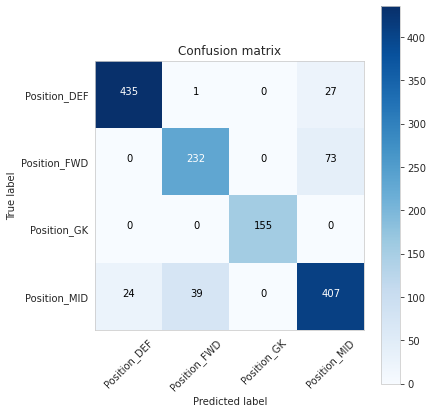

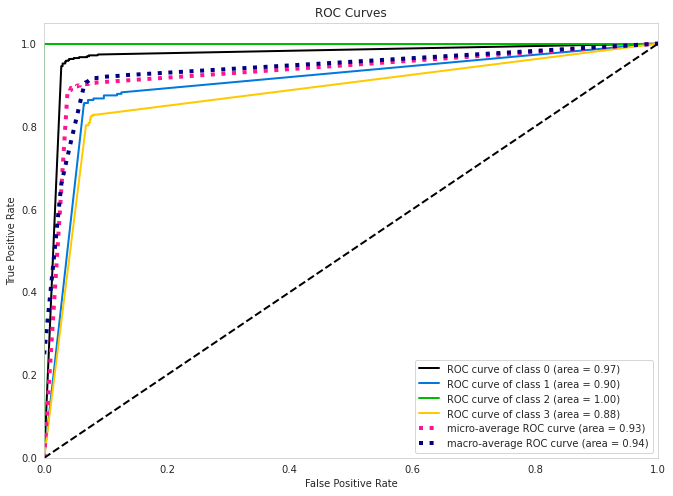

In [46]:
show_summary(y_true, y_pred, y_pred_proba, labels=list(y_val.columns.values))

### Predict on test

In [47]:
test_set = pd.read_csv('./dataset/fifa2021_test.csv')
test_features, _ = preprocess(test_set)

In [48]:
y_pred = to_single_col_df(model.predict(test_features))
y_pred

,any
0,1
1,1
2,1
3,3
4,3
...,...
5904,0
5905,0
5906,2
5907,3
